In [1]:
%load_ext autoreload
%autoreload 2

%cd /home/rmhl/repos/stargraph

/home/rmhl/repos/stargraph


In [1]:
%load_ext autoreload
%autoreload 2
%cd /Users/perper/Documents/active-learning/mnistvae

/Users/perper/Documents/active-learning/mnistvae


In [88]:
pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "9"
os.environ["TF_USE_NVLINK_FOR_PARALLEL_COMPILATION"] = "0"
p = os.environ["PATH"]
os.environ["PATH"] = f"{p}:/usr/local/cuda/bin"

from functools import partial
import jax
import jax.numpy as jnp
from jaxtyping import PyTree
from torch.utils.data import DataLoader
import equinox as eqx
import matplotlib.pyplot as plt
import distrax as dsx
import optax
import seaborn as sns

sns.set()

#from data import SpokenMNISTMultimodalDataset
from model.image_vae import ImageVAE, ImageVAEOutput
from model.loss import ELBOLossOutput, get_evidence_lower_bound
from model.visualization import visualize_reconstructions


BATCH_SIZE = 32

RuntimeError: jaxlib version 0.4.20 is newer than and incompatible with jax version 0.4.13. Please update your jax and/or jaxlib packages.

In [90]:
pip install tensorflow-datasets

Note: you may need to restart the kernel to use updated packages.


In [91]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [92]:
import tensorflow_datasets as tfds

In [93]:
from typing import Iterator, Mapping, NamedTuple, Sequence, Tuple
import numpy as np

In [94]:
PRNGKey = jnp.ndarray
Batch = Mapping[str, np.ndarray]
batch_size = BATCH_SIZE
random_seed = 42

MNIST_IMAGE_SHAPE: Sequence[int] = (28, 28, 1)


def load_dataset(split: str, batch_size: int) -> Iterator[Batch]:
    ds = tfds.load(
        "binarized_mnist",
        split=split,
        shuffle_files=True,
        read_config=tfds.ReadConfig(shuffle_seed=random_seed),
    )
    ds = ds.shuffle(buffer_size=10 * batch_size, seed=random_seed)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=5)
    ds = ds.repeat()
    return iter(tfds.as_numpy(ds))


In [95]:
batch_size = 32
train_dataloader = load_dataset(tfds.Split.TRAIN, batch_size)
test_dataloader = load_dataset(tfds.Split.TEST, batch_size)

2023-11-12 00:45:22.949017: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


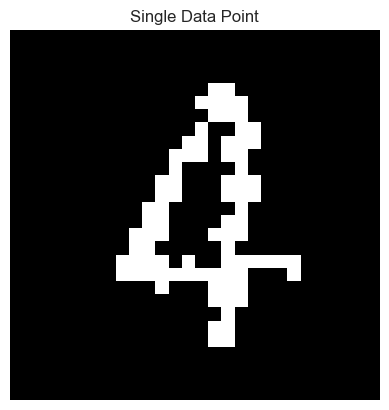

In [96]:
batch = next(train_dataloader)

# Take the first data point from the batch
data_point = batch['image'][0]
import matplotlib.pyplot as plt
plt.imshow(data_point.squeeze(), cmap='gray')  # Use 'gray' for grayscale images
plt.title('Single Data Point')
plt.axis('off')
plt.show()

In [97]:
#from data import SpokenMNISTMultimodalDataset

In [98]:
# train_dataloader = DataLoader(
#     SpokenMNISTMultimodalDataset(split="train"),
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     num_workers=1,
# )
# test_dataloader = DataLoader(
#     SpokenMNISTMultimodalDataset(split="test"),
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     num_workers=1,
# )

In [99]:
pip install jax==0.4.13


Note: you may need to restart the kernel to use updated packages.


In [100]:
import jax
#print(jax.__version__)

In [101]:
print(jax.__version__)

0.4.20


In [102]:
from model.encoder import ImageEncoder

key = jax.random.PRNGKey(0)
encoder = ImageEncoder(in_channels=1, out_channels=2, key=key)
encoder_fn = jax.vmap(encoder)
#image_input_example = jax.random.normal(key, (32, 32))
#encoder_output = encoder(image_input_example)
#encoder_output
batch = batch[..., 0]
#targets = pad_fn(batch)
#encoder_fn(batch)
batch.shape

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/perper/miniconda3/envs/equinoxvae/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/zn/bs_918_s1_n79q1pywwjcw_w0000gn/T/ipykernel_69305/2487213651.py", line 3, in <module>
    key = jax.random.PRNGKey(0)
  File "/Users/perper/miniconda3/envs/equinoxvae/lib/python3.10/site-packages/jax/_src/random.py", line 224, in PRNGKey
    if key.ndim:
  File "/Users/perper/miniconda3/envs/equinoxvae/lib/python3.10/site-packages/jax/_src/random.py", line 178, in _key
  File "/Users/perper/miniconda3/envs/equinoxvae/lib/python3.10/site-packages/jax/_src/random.py", line 155, in resolve_prng_impl
    if isinstance(seed, prng.PRNGKeyArray):
  File "/Users/perper/miniconda3/envs/equinoxvae/lib/python3.10/site-packages/jax/_src/random.py", line 121, in default_prng_impl
AttributeError: '_StateContextManager' object has no attribute 'value'

Duri

In [103]:
key = jax.random.PRNGKey(0)

model_key, key = jax.random.split(key)
model = ImageVAE(in_channels=1, n_latents=2, key=model_key)

optimizer = optax.adam(1e-3)
opt_state = optimizer.init(eqx.filter(model, eqx.is_array))

pad_fn = jax.vmap(partial(jnp.pad, pad_width=2))


@eqx.filter_value_and_grad(has_aux=True)
def grad_and_loss(model: eqx.Module, batch: jnp.array, key: jax.random.PRNGKey):
    model_fn = jax.vmap(model)
    loss_fn = jax.vmap(get_evidence_lower_bound)
    keys = jax.random.split(key, BATCH_SIZE)
    model_output: ImageVAEOutput = model_fn(batch, key=keys)
    loss_output: ELBOLossOutput = loss_fn(batch, model_output)
    return jnp.mean(loss_output["loss"]), jax.tree_map(jnp.mean, loss_output)


@eqx.filter_jit
def make_step(
    model: eqx.Module,
    opt_state: PyTree,
    batch: jnp.array,
    *,
    key: jax.random.PRNGKey,
):
    (loss, aux), grads = grad_and_loss(model, batch, key)
    updates, update_opt_state = optimizer.update(grads, opt_state)
    update_model = eqx.apply_updates(model, updates)
    return (loss, aux), update_model, update_opt_state


step = 0
MAX_EPOCHS = 10
train_metrics = None
for epoch in range(MAX_EPOCHS):
    for batch in train_dataloader:
        batch = jnp.asarray(batch["image"]).astype(jnp.float32)
        batch =  batch[..., 0]
        targets = pad_fn(batch)
        key, binarized_key = jax.random.split(key)
        targets = (
            dsx.Bernoulli(probs=targets).sample(seed=binarized_key).astype(jnp.float32)
        )

        #targets = targets[..., 0]
        #print(targets.shape)
        key, step_key = jax.random.split(key)
        (loss, aux), model, opt_state = make_step(
            model, opt_state, targets, key=step_key
        )

        step += 1
        if step % 500 == 0:
            if train_metrics is None:
                train_metrics = {k: jnp.array([v]) for k, v in aux.items()}
                train_metrics["step"] = jnp.array([step])
            else:
                for k, v in aux.items():
                    train_metrics[k] = jnp.concatenate(
                        [train_metrics[k], jnp.array([v])]
                    )
                train_metrics["step"] = jnp.concatenate(
                    [train_metrics["step"], jnp.array([step])]
                )

            log_str = f"step/epoch: {step}/{epoch}"
            for k, v in aux.items():
                log_str += f"\t {k}: {v:.3f}"
            print(log_str)

visualize_reconstructions(model, targets)

K = len(train_metrics) - 1
plt.figure(figsize=(4 * K, 4))
for i, (k, v) in enumerate(train_metrics.items()):
    if k == "step":
        continue
    plt.subplot(1, K, i + 1)
    plt.title(k)
    plt.plot(train_metrics["step"], v)
    plt.xlabel("Optimization step")

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/perper/miniconda3/envs/equinoxvae/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/zn/bs_918_s1_n79q1pywwjcw_w0000gn/T/ipykernel_69305/3661057274.py", line 1, in <module>
    key = jax.random.PRNGKey(0)
  File "/Users/perper/miniconda3/envs/equinoxvae/lib/python3.10/site-packages/jax/_src/random.py", line 224, in PRNGKey
    if key.ndim:
  File "/Users/perper/miniconda3/envs/equinoxvae/lib/python3.10/site-packages/jax/_src/random.py", line 178, in _key
  File "/Users/perper/miniconda3/envs/equinoxvae/lib/python3.10/site-packages/jax/_src/random.py", line 155, in resolve_prng_impl
    if isinstance(seed, prng.PRNGKeyArray):
  File "/Users/perper/miniconda3/envs/equinoxvae/lib/python3.10/site-packages/jax/_src/random.py", line 121, in default_prng_impl
AttributeError: '_StateContextManager' object has no attribute 'value'

Duri